In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# View Masurement table columns
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2e07ef7b0b8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
# View Station table columns
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2e07ef7b780>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

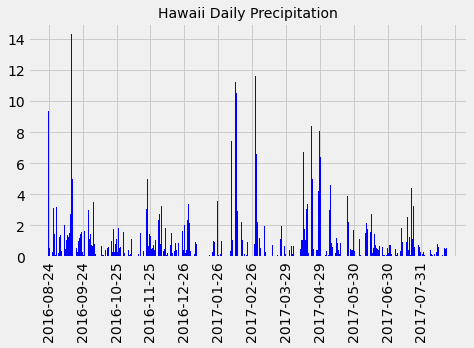

In [12]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#session.query(Measurement.date).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).count()

# Perform a query to retrieve the data and precipitation scores
from sqlalchemy.sql import func
sel = [func.sum(Measurement.prcp), Measurement.date]

rainfall = session.query(*sel).\
    order_by(Measurement.date).\
    filter(Measurement.date >= '2016-08-24').\
    group_by(Measurement.date).all()
rainfall

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(rainfall, columns=["Precipitation", "Date"]).set_index("Date")
df.head(50)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(7,4))
plt.xticks(rotation=90)
plt.title("Hawaii Daily Precipitation", fontsize=14)
ax.bar(df.index, df["Precipitation"], color="b")
ax.xaxis.set_major_locator(ticker.MultipleLocator(31))


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [14]:
# Design a query to show how many stations are available in this dataset?

# Simple queries on Station database returns 9 unique stations
session.query(Station.station).all()
session.query(Station.station).count()

# Confirm results by using groupby function in Measurement databse; also returns 9 stations
session.query(Measurement.station).group_by(Measurement.station).all()
session.query(Measurement.station).group_by(Measurement.station).count()


9

In [15]:
## What are the most active stations? (i.e. what stations have the most rows)?
# Use count function on tempurature observations to determine overall activity
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).all()
active_stations

# List the stations and the counts in descending order.
pd.DataFrame(active_stations, columns=["Stations", "Total TOBS"]).sort_values(by="Total TOBS", ascending=False)


,Stations,Total TOBS
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

low_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
low_temp

high_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
high_temp

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
avg_temp

print(high_temp, low_temp, avg_temp)

[('USC00519281', 85.0)] [('USC00519281', 54.0)] [('USC00519281', 71.66378066378067)]


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

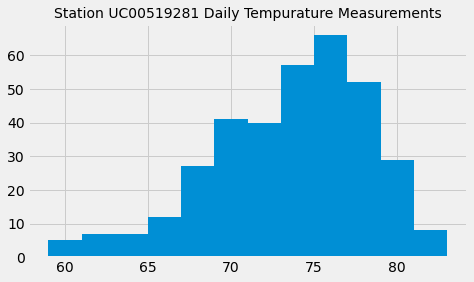

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= '2016-08-24').all()

df1 = pd.DataFrame(temps, columns=["Daily Temp"])

# Plot results as a histogram
fig, ax = plt.subplots(figsize=(7,4))
plt.title("Station UC00519281 Daily Tempurature Measurements", fontsize=14)
ax.hist(df1["Daily Temp"], bins=12)




## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [18]:
# Double check station activity in last year vs full dataset:

active_stations1 = session.query(Measurement.station, func.count(Measurement.tobs)).\
    filter(Measurement.date >= '2016-08-24').\
    group_by(Measurement.station).all()
active_stations1



[('USC00513117', 342),
 ('USC00514830', 304),
 ('USC00516128', 348),
 ('USC00517948', 182),
 ('USC00519281', 351),
 ('USC00519397', 360),
 ('USC00519523', 336)]